# 03 - Baseline: TF–IDF + Logistic Regression

In this notebook we will:
1. Load our train/val/test splits for a chosen task (HH, SP, or BD)  
2. Clean the text using our `clean_text()` function  
3. Fit a TF–IDF → LogisticRegression pipeline with 5‑fold CV to tune C  
4. Evaluate on the validation set (classification report, PR‑AUC)  
5. Plot precision‑recall curve and confusion matrix  
6. Save the best model for later use  


In [5]:
# — Choose task —
# Options: "hh" (helpfulness), "sp" (sentiment), "bd" (burst/duplicate)
TASK = "sp"


In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, confusion_matrix
import joblib

%matplotlib inline
plt.style.use('ggplot')


In [7]:
# Re‐define clean_text inline (copy from preprocessing)
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    txt = text.lower()
    txt = re.sub(r'<[^>]+>', ' ', txt)
    txt = re.sub(r'http\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    tokens = [w for w in txt.split() if w not in STOP]
    return ' '.join(lemmatizer.lemmatize(w) for w in tokens)


In [10]:
# Load splits
train = pd.read_csv(f"project_splits/{TASK}_train.csv")
val   = pd.read_csv(f"project_splits/{TASK}_val.csv")
test  = pd.read_csv(f"project_splits/{TASK}_test.csv")

print(f"Train: {len(train):,}   Val: {len(val):,}   Test: {len(test):,}")
print("Class balance (train):")
print(train['label'].value_counts(normalize=True).map("{:.2%}".format))


Train: 368,069   Val: 52,581   Test: 105,164
Class balance (train):
label
1    84.40%
0    15.60%
Name: proportion, dtype: object


In [11]:
# Apply cleaning to text
for df_ in (train, val, test):
    df_["cleaned"] = df_["Text"].apply(clean_text)


In [15]:
import time
# Build pipeline & grid
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="saga"))
])

param_grid = {
    "clf__C": [0.1, 1.0, 3.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit on TRAIN
fit_start_time = time.time()
grid.fit(train["cleaned"], train["label"])
fit_time = time.time() - fit_start_time

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [16]:
# Best hyperparameters & CV score
print("Best params:", grid.best_params_)
print("Best CV F1 :", grid.best_score_.round(4))
print(f'Fitting Time: {fit_time:.4f}s')

Best params: {'clf__C': 3.0}
Best CV F1 : 0.954
Fitting Time: 179.1958s


In [18]:
# Evaluate on VAL
y_val_pred  = grid.predict(val["cleaned"])
y_val_proba = grid.predict_proba(val["cleaned"])[:,1]

print(classification_report(val["label"], y_val_pred, digits=3))
print("PR‑AUC:", f'{average_precision_score(val["label"], y_val_proba):.4f}')


              precision    recall  f1-score   support

           0      0.695     0.909     0.788      8204
           1      0.982     0.926     0.953     44377

    accuracy                          0.924     52581
   macro avg      0.839     0.918     0.871     52581
weighted avg      0.937     0.924     0.928     52581

PR‑AUC: 0.9945


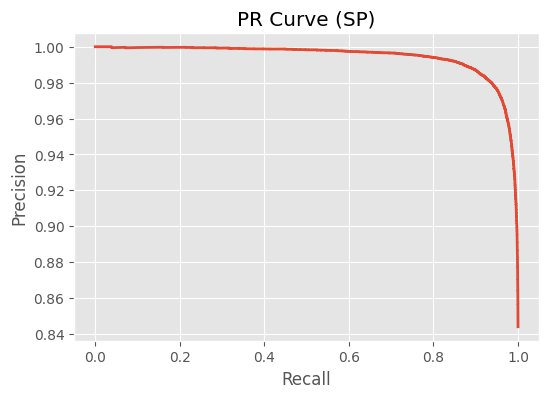

In [19]:
# Precision‑Recall curve
prec, rec, thr = precision_recall_curve(val["label"], y_val_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve ({TASK.upper()})")
plt.show()


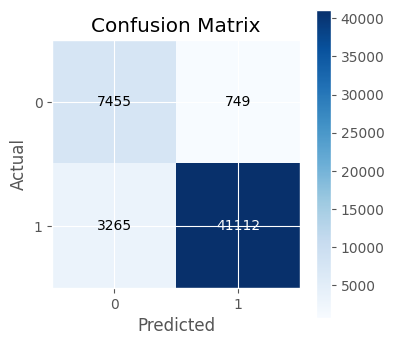

In [20]:
# Confusion matrix
cm = confusion_matrix(val["label"], y_val_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks([0,1]); ax.set_xticklabels(["0","1"])
ax.set_yticks([0,1]); ax.set_yticklabels(["0","1"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
for i in (0,1):
    for j in (0,1):
        ax.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.title("Confusion Matrix")
plt.show()


In [21]:
# Save best model
model_path = f"models/{TASK}_tfidf_logreg.joblib"
vectorizer_path = f"models/{TASK}_tfidf_vectorizer.joblib"
grid.best_estimator_.named_steps["tfidf"]
# Dump full pipeline
joblib.dump(grid.best_estimator_, model_path)
print("Saved pipeline to", model_path)


Saved pipeline to models/sp_tfidf_logreg.joblib
